In [1]:
# Notre DIP
!git clone https://github.com/quentgar/deep_image_prior.git
!mv deep_image_prior/* ./

!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep_image_prior'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 64 (delta 10), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (64/64), done.
Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 22.73 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from src.hourglass_network import *
import torch
import torch.optim

from utils.inpainting_utils import *
from skimage.measure import compare_psnr
from skimage.measure import block_reduce

import time

from mpl_toolkits.axes_grid1 import ImageGrid

import cv2

import matplotlib
from PIL import Image

from scipy.ndimage import gaussian_filter

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 8

In [3]:
#Test pont
img_path = 'mydata/pont.jpg'
mask_path = 'mydata/pont_mask_7.jpg'

In [4]:
def crop_perso(img,d=32):
   new_size = (img.shape[0] - img.shape[0] % d, 
                img.shape[1] - img.shape[1] % d)

   img_cropped = img[int((img.shape[0] - new_size[0])/2):int((img.shape[0] + new_size[0])/2),
                     int((img.shape[1] - new_size[1])/2):int((img.shape[1] + new_size[1])/2)]
                     
   return img_cropped

In [5]:
def redim(img_orig, img_prec):
  new_size = (min(img_orig.shape[1], img_prec.shape[1]),
              min(img_orig.shape[2], img_prec.shape[2]))
  
  img_orig = img_orig[:,int((img_orig.shape[1] - new_size[0])/2):int((img_orig.shape[1] + new_size[0])/2),
                     int((img_orig.shape[2] - new_size[1])/2):int((img_orig.shape[2] + new_size[1])/2)]

  img_prec = img_prec[:,int((img_prec.shape[1] - new_size[0])/2):int((img_prec.shape[1] + new_size[0])/2),
                      int((img_prec.shape[2] - new_size[1])/2):int((img_prec.shape[2] + new_size[1])/2)]

  return img_orig, img_prec

## Image de base

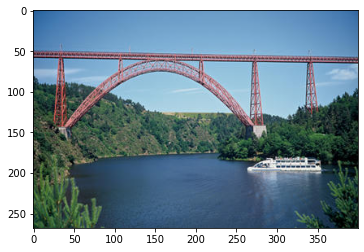

In [6]:
img_pil, img_np = get_image(img_path, imsize)
plt.imshow(img_np.transpose(1,2,0))

# Multi scale DIP

In [7]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

dim_div_by_list = [8,16,32,64]
num_iter_list = [1000,1200,2000,3000]

In [13]:
start_time = time.time()

DOWN_INTER = cv2.INTER_NEAREST
UP_INTER = cv2.INTER_LINEAR

INPUT = 'noise'
input_depth = 2
LR = 0.01
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03

iter_etape_1 = 200
max_etage = 3

# Loss
mse = torch.nn.MSELoss().type(dtype)

for e in range(max_etage,-1,-1):

  print("\nETAGE ",e,"\n")

  # Facteurs de sous et sur échantillonnage
  down_factor = 1/(2**e)
  up_factor = 1/down_factor

  dim_div_by = dim_div_by_list[max_etage-e]
  num_iter = num_iter_list[max_etage-e]

  # Image de base sous échantillonnée
  img_d = cv2.resize(img_np.transpose(1,2,0),None,fx=down_factor,fy=down_factor,interpolation=DOWN_INTER)

  # Rogner l'image : div_dim_by à changer en fonction de e ?
  img_d = crop_perso(img_d, dim_div_by)
  img_d = img_d.transpose(2,0,1)

  print("\n Taille image :",img_d.shape,"\n")

  # S'assurer que image originale downsampled même dim que image précédente upsampled
  if e != max_etage:
    img_d, img_prec = redim(img_d, img_prec)
    prec_var = np_to_torch(img_prec).type(dtype)
    print("\n Taille prec :",img_prec.shape)
    print("Taille image après modif :",img_d.shape,"\n")

  # Charger le masque à la dimension de img_d et arrondir
  img_mask_pil, img_mask_np = get_image(mask_path, (img_d.shape[2],img_d.shape[1]))
  img_mask_np = np.round(img_mask_np)

  print("\n Taille masque :",img_mask_np.shape,"\n")

  # Complémentaire du mask
  img_comp_mask_np = 1 - img_mask_np

  img_var = np_to_torch(img_d).type(dtype)
  mask_var = np_to_torch(img_mask_np).type(dtype)
  comp_mask_var = np_to_torch(img_comp_mask_np).type(dtype)

  # Création du réseau
  if e > 0:
    depth = 5 - e + 1
  else:
    depth = 5
    
  """
  net = build_hourglass(input_depth, output_depth=img_np.shape[0], 
               num_channels_down = [128]*depth,
               num_channels_up =   [128]*depth,
               num_channels_skip =    [0]*depth,  
               filter_size_up = 5, filter_size_down = 5, 
               up_samp_mode='nearest', filter_skip_size=1,num_scales=depth).type(dtype)"""

  net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * depth,
               num_channels_up   = [128] * depth,
               num_channels_skip = [0] * depth,  
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=5, filter_size_down=5,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

  net_input = get_noise(input_depth, INPUT, img_d.shape[1:]).type(dtype)

  i = 0
  list_iter = []
  list_psnr = []
  list_loss = []
  def closure():
      
      global i, list_iter, list_psnr, list_loss, e
      
      if param_noise:
          for n in [x for x in net.parameters() if len(x.size()) == 4]:
              n = n + n.detach().clone().normal_() * n.std() / 50
      
      net_input = net_input_saved
      if reg_noise_std  > 0:
          net_input = net_input_saved + (noise.normal_() * reg_noise_std)
          
          
      out = net(net_input)
    
      if e != max_etage and i <= iter_etape_1:
        total_loss = mse(out, img_var * mask_var + prec_var * comp_mask_var)
      else:
        total_loss = mse(out * mask_var, img_var * mask_var)

      total_loss.backward()
          
      if PLOT and i % show_every == 0:
          print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
          
          out_np = torch_to_np(out)
          list_iter.append(i)
          list_psnr.append(compare_psnr(img_d,out_np))
          list_loss.append(total_loss.item())
          plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
          
      i += 1

      return total_loss

  net_input_saved = net_input.detach().clone()
  noise = net_input.detach().clone()

  p = get_params(OPT_OVER, net, net_input)
  optimize(OPTIMIZER, p, closure, LR, num_iter)

  plt.figure()
  plt.plot(list_iter,list_psnr,linestyle='-')
  plt.title("PSNR en fonction du nombre d'itérations")
  plt.xlabel("Nombre d'itérations")
  plt.show()

  out_np = torch_to_np(net(net_input))
  if e > 0:
    img_prec = cv2.resize(out_np.transpose(1,2,0),None,fx=2,fy=2,interpolation=UP_INTER)
    img_prec = img_prec.transpose(2,0,1)
    print("\nImage sortie upsampled :",img_prec.shape,"\n")

end_time = time.time()

Output hidden; open in https://colab.research.google.com to view.

In [9]:
  total_time = end_time - start_time
minutes = int(total_time // 60)
secondes = int(total_time % 60)
print("--- %s minutes %s secondes ---" % (minutes, secondes))

--- 25 minutes 21 secondes ---


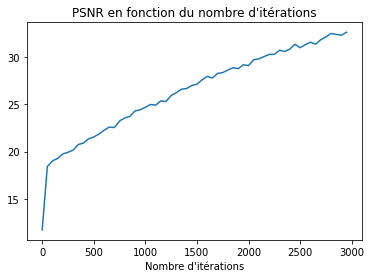

In [10]:
plt.figure()
plt.plot(list_iter,list_psnr,linestyle='-')
plt.title("PSNR en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

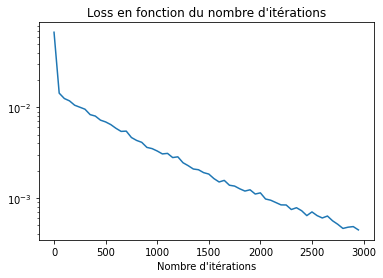

In [11]:
plt.figure()
plt.semilogy(list_iter,list_loss,linestyle='-')
plt.title("Loss en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

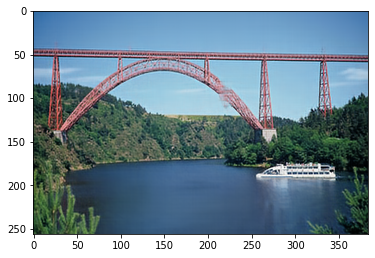

In [12]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

In [ ]:
out_np.shape

(576, 768, 3)

In [ ]:
img_np = crop_perso(img_np)
img_np.shape

(768, 0, 576)

In [ ]:
img_np, out_np = redim(img_np.transpose(1,2,0), out_np.transpose(1,2,0))
compare_psnr(img_np,out_np)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


27.78124201472312

In [ ]:
max(list_psnr)

38.14815247194498

ValueError: ignored

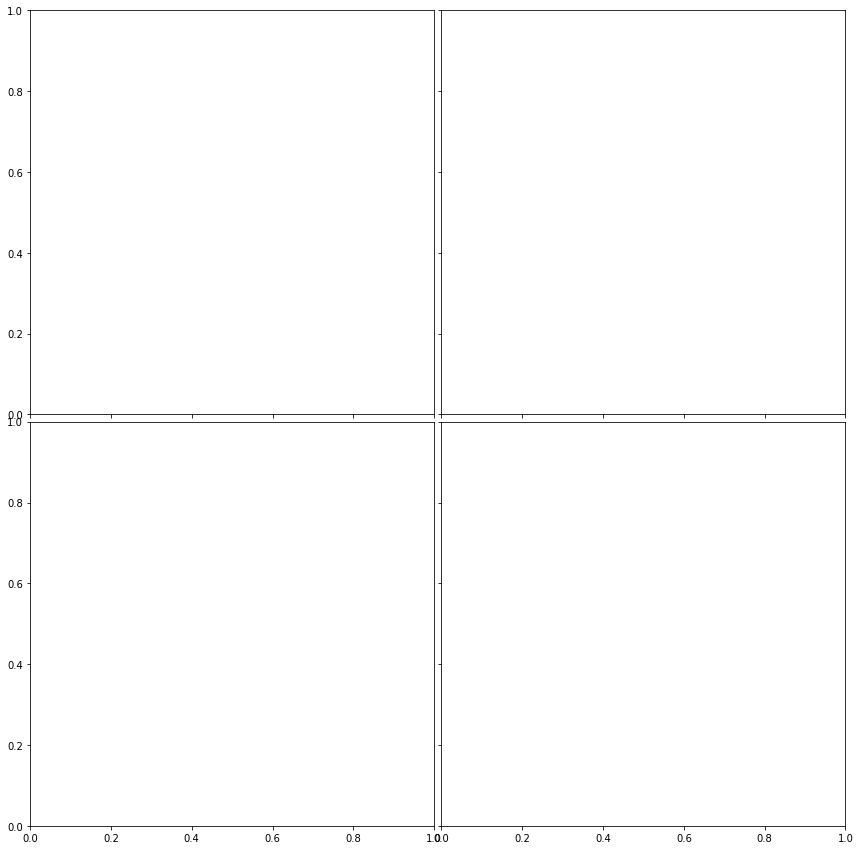

In [ ]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [img_mask_np, img_mask_np*img_np, out_np.transpose(2,0,1), img_np.transpose(2,0,1)]):
    # Iterating over the grid returns the Axes.
    #a = im.reshape((im.shape[1],im.shape[2]))
    #b = np.repeat(a[:, :, np.newaxis], 3, axis=2)
    ax.imshow(im.transpose(1,2,0))

plt.show()

In [17]:
img_np[0,:,:]

array([[0.14509805, 0.14509805, 0.14901961, ..., 0.19607843, 0.19215687,
        0.19215687],
       [0.14509805, 0.14901961, 0.15294118, ..., 0.20392157, 0.2       ,
        0.19607843],
       [0.14901961, 0.15294118, 0.15294118, ..., 0.21176471, 0.20784314,
        0.20392157],
       ...,
       [0.09411765, 0.06666667, 0.07058824, ..., 0.07843138, 0.00784314,
        0.00392157],
       [0.13333334, 0.06666667, 0.05098039, ..., 0.11372549, 0.03921569,
        0.        ],
       [0.25882354, 0.07843138, 0.03529412, ..., 0.08235294, 0.05490196,
        0.0627451 ]], dtype=float32)

In [62]:
a = np.array([[9, 19, 45],[3, 6, 8],[5, 78, 100]])
b = a.flatten()
print(a)

[[ 9 19]
 [ 3  6]]


In [63]:
ind = [x for x in range(9)]

In [64]:
v = np.array([[1, -1], [1, -1]])
v = v.flatten()
print(v)

[[ 1 -1]
 [ 1 -1]]


In [65]:
c = ind + v
d = c.flatten()
print(d)

[1 0 3 2]


In [66]:
b[d].reshape((2,2))

array([[19,  9],
       [ 6,  3]])